In [1]:
!pip install pyomo
import numpy as np
from pyomo.environ import *
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 8.0 MB/s 
     |████████████████████████████████| 49 kB 2.9 MB/s 


In [2]:
returns = np.array([0.0476, 0.004]) #  mu 
varcov = np.matrix([[2.12, 1.03], [1.03, 1.89]]) # sigma_ij
rfr = 0 # risk free rate 

n = len(returns) # number of assets

In [3]:
model = ConcreteModel() # Pyomo uses a ConcreteModel object to link the constraints, objective function, and variables together. So the first step is to instantiate it so we can add these features as attributes.

In [4]:
# Sets and indices

model.i = RangeSet(0, n-1)

In [5]:
# Decision variables 
model.f = Var(model.i, domain=UnitInterval)

# Parameters
model.mu = Param(model.i,
                 initialize={i: m for i, m in zip(model.i, returns)})

model.sigma = Param(model.i, model.i, initialize={(i,j): varcov[i, j] for i in model.i for j in model.i})

In [6]:
@model.Constraint()
def fullyInvestedConstraint(model):
  return sum(model.f[i] for i in model.i) == 1

In [7]:
# Objective function 
@model.Objective(sense=maximize)
def objective(model):
  return (rfr + sum(model.f[i] * (model.mu[i] - rfr) for i in model.i) - sum(
      sum(model.f[i] * model.sigma[i, j] * model.f[j] for j in model.i)
      for i in model.i) / 2)

In [8]:
@model.Objective(sense=maximize)
def objective(m):
  return (rfr + sum(m.f[i] * (m.mu[i] - rfr) for i in m.i) - sum(
              sum(m.f[i] * m.sigma[i, j] * m.f[j] for j in m.i)
          for i in m.i) / 2)



    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [9]:
def buildKCOptModel(returns: np.array, varcov: np.matrix, 
                    rfr: float = 0, lam_max: float = 3):

  m = ConcreteModel()

  # Indices
  m.i = RangeSet(0, returns.shape[0] - 1)

  # Decision variables
  m.f = Var(m.i, domain=Reals)
  m.x = Var(m.i, domain=Reals)

  # Parameters
  m.mu = Param(m.i, 
               initialize={i: m for i, m in zip(m.i, returns)})
  m.sigma = Param(m.i, m.i, 
                  initialize={(i, j): varcov[i, j] 
                              for i in m.i 
                              for j in m.i})
  m.lam_max = lam_max

  # Constraints
  @m.Constraint()
  def maxLeverageConstraint(m):
    return sum(m.x[i] for i in m.i) <= m.lam_max

  @m.Constraint(m.i)
  def posFraction(m, i):
    return m.x[i] - m.f[i] >= 0

  @m.Constraint(m.i)
  def negFraction(m, i):
    return m.x[i] + m.f[i] >= 0

  Objective
  @m.Objective(sense=maximize)
  def objective(m):
    return (rfr + sum(m.f[i] * (m.mu[i] - rfr) for i in m.i) - \
            sum(
                sum(m.f[i] * m.sigma[i, j] * m.f[j] for j in m.i)
            for i in m.i) / 2)

  return m

In [10]:
m = buildKCOptModel(returns, varcov, rfr)
m.pprint()

1 Set Declarations
    sigma_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*i :    4 : {(0, 0), (0, 1), (1, 0), (1, 1)}

1 RangeSet Declarations
    i : Dimen=1, Size=2, Bounds=(0, 1)
        Key  : Finite : Members
        None :   True :   [0:1]

2 Param Declarations
    mu : Size=2, Index=i, Domain=Any, Default=None, Mutable=False
        Key : Value
          0 : 0.0476
          1 :  0.004
    sigma : Size=4, Index=sigma_index, Domain=Any, Default=None, Mutable=False
        Key    : Value
        (0, 0) :  2.12
        (0, 1) :  1.03
        (1, 0) :  1.03
        (1, 1) :  1.89

2 Var Declarations
    f : Size=2, Index=i
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :  None :  None : False :  True :  Reals
          1 :  None :  None :  None : False :  True :  Reals
    x : Size=2, Index=i
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :  None

In [11]:
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64


In [12]:
results = SolverFactory('ipopt', executable='/content/ipopt').solve(model)
print(f"g = {model.objective.expr():.3f}")
print(f"Fractions = {[np.round(model.f[i].value, 3) for i in model.i]}")


g = -0.732
Fractions = [0.463, 0.537]


In [13]:
{i * m for i, m in zip([1,2], returns)}

{0.008, 0.0476}

In [14]:
{(i,j): varcov[i, j] for i in model.i for j in model.i}

{(0, 0): 2.12, (0, 1): 1.03, (1, 0): 1.03, (1, 1): 1.89}

# Optimizing a Stock Portfolio with Yahoo Finance Data


In [15]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 10.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [67]:
start = '2020-01-01'
end = '2021-12-31'
tickers = ['AAPL', 'F', 'GE', 'CVX']
tickers = ['AAPL', 'F']
yfObj = yf.Tickers(tickers)
data = yfObj.history(start=start, end=end)
data.drop(['High', 'Low', 'Open', 'Volume', 'Stock Splits', 'Dividends'],
        axis=1, inplace=True)
data.columns = data.columns.swaplevel()

[*********************100%***********************]  2 of 2 completed


,AAPL,F
,Close,Close
Date,,
2020-01-02,73.785912,9.108328
2020-01-03,73.068573,8.905276
2020-01-06,73.650810,8.856930
2020-01-07,73.304405,8.943953
2020-01-08,74.483597,8.943953
...,...,...
2021-12-23,175.797394,20.013264
2021-12-27,179.836319,20.556833


In [17]:
def getKCOpt(data: pd.DataFrame, lookback=252, rfr=0):
  returns = data.loc[:, (slice(None), 'Close')] / \
    data.loc[:, (slice(None), 'Close')].shift(1)
  returns = returns.rename(columns={'Close': 'returns'})
  means = returns.rolling(lookback).mean().rename(
    columns={'returns': 'mean'})
  var = returns.rolling(lookback).var().rename(
    columns={'returns': 'var'})
  df = pd.concat([returns, means, var], axis=1)
  # Get covariance matrices and transform to 3D array
  n = returns.shape[1]
  cov = returns.droplevel(1, axis=1).rolling(lookback).cov().values.reshape(
      -1, n, n)
  
  fracs = np.zeros((df.shape[0], n))
  fracs[:] = np.nan
  g = np.zeros(df.shape[0])
  g[:] = np.nan

  for i, (ts, row) in enumerate(df.iterrows()):
    if i < lookback:
      continue
    means = row.loc[(slice(None), 'mean')].values
    var = row.loc[(slice(None), 'var')].values
    varcov = cov[i]
    np.fill_diagonal(varcov, var)
    model = buildKCOptModel(means, varcov, rfr)
    results = SolverFactory('ipopt', executable='/content/ipopt').solve(model)
    fracs[i] = np.array([model.f[j].value for j in model.f])
    g[i] = model.objective.expr()

  df_fracs = pd.DataFrame(fracs, columns=returns.columns, 
                          index=returns.index).rename(
                              columns={'returns': 'fraction'})
  df_g = pd.DataFrame(g, index=returns.index)
  df_g.columns = pd.MultiIndex.from_arrays(
      [['g'], ['g']])

  return pd.concat([data, df, df_fracs, df_g], axis=1)
df = getKCOpt(data)


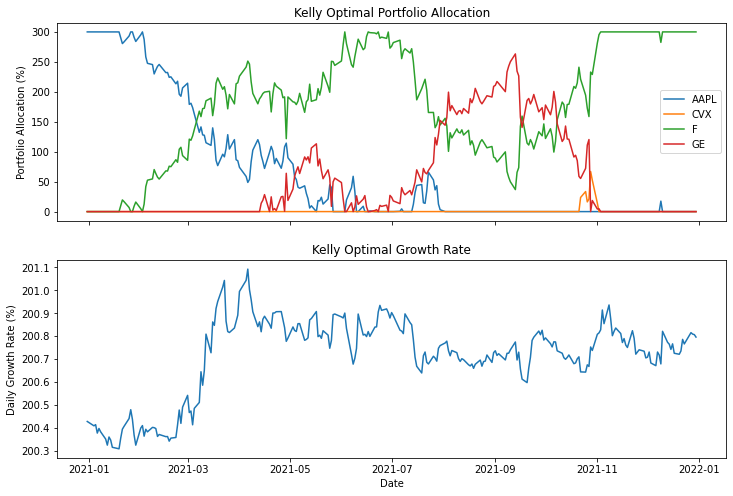

In [18]:
df = getKCOpt(data)

fig, ax = plt.subplots(2, figsize=(12, 8), sharex=True)

ax[0].plot(df.loc[:, (slice(None), 'fraction')] * 100)
ax[0].set_ylabel('Portfolio Allocation (%)')
ax[0].set_title('Kelly Optimal Portfolio Allocation')
labels = [i for i in list(df.columns.levels[0]) if i in tickers]
ax[0].legend(labels=labels)

ax[1].plot((df.loc[:, 'g'] - 1) * 100)

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Daily Growth Rate (%)')
ax[1].set_title('Kelly Optimal Growth Rate')

plt.show()

In [19]:
# importing libraries
import time
import math
 
# decorator to calculate duration
# taken by any function.
def calculate_time(func):
    print(10)
     
    # added arguments inside the inner1,
    # if function takes any arguments,
    # can be added like this.
    def inner1(*args, **kwargs):
 
        # storing time before function execution
        begin = time.time()
        print(begin)
        func(*args, **kwargs)
 
        # storing time after function execution
        end = time.time()
        print("Total time taken in : ", func.__name__, end - begin)
 
    return inner1
 
 
 
# this can be added to any function present,
# in this case to calculate a factorial
@calculate_time
def factorial1(num):
 
    # sleep 2 seconds because it takes very less time
    # so that you can see the actual difference
    time.sleep(10)
# calling the function.
factorial1(10)

10
1653799580.2354698
Total time taken in :  factorial1 10.000777006149292


In [20]:
def hello_decorator(func):
    def inner1(*args, **kwargs):
        print(**kwargs)
         
        print("before Execution")
         
        # getting the returned value
        returned_value = func(*args, **kwargs)
        print("after Execution")
         
        # returning the value to the original frame
        return returned_value
         
    return inner1
 
 
# adding decorator to the function
@hello_decorator
def sum_two_numbers(a, b):
    print("Inside the function")
    return a + b
 
a, b = 1, 2
 
# getting the value through return of the function
print("Sum =", sum_two_numbers(a, b))


before Execution
Inside the function
after Execution
Sum = 3


In [21]:
def decor1(func):
    def inner():
        x = func()
        return x * x
    return inner
 
def decor(func):
    def inner():
        x = func()
        return 2 * x
    return inner
 
@decor1
@decor
def num():
    return 10
 
print(num())

400


In [22]:
# Install IPOPT
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

In [23]:
def buildKCOptModel(returns: np.array, varcov: np.matrix, 
                    rfr: float = 0, lam_max: float = 3):

  m = ConcreteModel()

  # Indices
  m.i = RangeSet(0, returns.shape[0] - 1)

  # Decision variables
  m.f = Var(m.i, domain=Reals)
  m.x = Var(m.i, domain=Reals)

  # Parameters
  m.mu = Param(m.i, 
               initialize={i: m for i, m in zip(m.i, returns)})
  m.sigma = Param(m.i, m.i, 
                  initialize={(i, j): varcov[i, j] 
                              for i in m.i 
                              for j in m.i})
  m.lam_max = lam_max

  # Constraints
  @m.Constraint()
  def maxLeverageConstraint(m):
    return sum(m.x[i] for i in m.i) <= m.lam_max

  @m.Constraint(m.i)
  def posFraction(m, i):
    return m.x[i] - m.f[i] >= 0

  @m.Constraint(m.i)
  def negFraction(m, i):
    return m.x[i] + m.f[i] >= 0

  Objective
  @m.Objective(sense=maximize)
  def objective(m):
    return (rfr + sum(m.f[i] * (m.mu[i] - rfr) for i in m.i) - \
            sum(
                sum(m.f[i] * m.sigma[i, j] * m.f[j] for j in m.i)
            for i in m.i) / 2)

  return m

In [91]:
# !pip install yfinance
import yfinance as yf

class OptimalAllocation:

  def __init__(self, tickers: list, max_leverage: float=3, lookback: int=252,
               rfr: float=0, start: str="2000-01-01", end: str="2021-12-31",
               rebalance_freq: int=1):
    self.tickers = tickers
    self.max_leverage = max_leverage
    self.lookback = lookback
    self.start = start
    self.end = end
    self.rfr = rfr
    self.rebalance_freq = rebalance_freq

    self.data = self._getData()
    self._calcStats()

  def _getData(self):
    yfObj = yf.Tickers(self.tickers)
    data = yfObj.history(start=self.start, end=self.end)
    data.drop(["High", "Low", "Open", "Volume", "Stock Splits", "Dividends"],
              axis=1, inplace=True)
    data.columns = data.columns.swaplevel()
    data.dropna(inplace=True)
    return data

  def _calcStats(self):
    # Calc returns
    returns = self.data.loc[:, (slice(None), "Close")] / \
      self.data.loc[:, (slice(None), "Close")].shift(1)
    returns = returns.rename(columns={"Close": "returns"})
    
    means = returns.rolling(self.lookback).mean().rename(
        columns={"returns": "mean"})

    # Calculate covariance matrices and transform to 3D array
    n = returns.shape[1]
    self.cov = returns.droplevel(1, axis=1).rolling(
        self.lookback).cov().values.reshape(-1, n, n)
    self.data = pd.concat([self.data, returns, means], axis=1)
    

  def calcKCUnconstrainedAllocation(self):
    '''
    Calculates the allocation fractions for the unconstrained 
    Kelly Criterion case.
    '''
    fracs = np.zeros((len(self.data), len(self.tickers)))
    fracs[:] = np.nan

    for i, (ts, row) in enumerate(self.data.iterrows()):
      if i < self.lookback:
        continue

      means = row.loc[(slice(None)), "mean"].values
    
      F = np.dot(means, np.linalg.inv(self.cov[i]))
      fracs[i] = F

    df_fracs = pd.DataFrame(fracs, index=self.data.index)
    midx = pd.MultiIndex.from_arrays(
        [self.tickers, len(self.tickers)*['unconstrained_fracs']])
    df_fracs.columns = midx
    return df_fracs

  def calcKCHeuristicAllocation(self, kelly_level: float=1):
    '''
    Calculates the allocation fractions using a simple max leverage heuristic
    for the Kelly Criterion.

    kelly_level: allows setting to full kelly (1) half-kelly (0.5) or any
      other multiple. This takes the solution from the QP and scales it down
      accordingly to reduce actual leverage.
    '''
    df_fracs = self.calcKCUnconstrainedAllocation()
    heur_fracs = df_fracs.apply(
        lambda x: kelly_level * self.max_leverage * np.abs(x) / \
          np.abs(x).sum() * np.sign(x), 
        axis=1)
    heur_fracs = heur_fracs.rename(
        columns={'unconstrained_fracs': 'heuristic_fracs'})
    return heur_fracs

  def calcKCQuadProdAllocation(self, kelly_level: float=1):
    '''
    Calculates optimal allocation fractions by solving a quadratic program
    according to the Kelly Criterion.

    kelly_level: allows setting to full kelly (1) half-kelly (0.5) or any
      other multiple. This takes the solution from the QP and scales it down
      accordingly to reduce actual leverage.
    '''
    fracs = np.zeros((len(self.data), len(self.tickers)))
    fracs[:] = np.nan
    g = fracs[:, 0].copy()

    for i, (ts, row) in enumerate(self.data.iterrows()):
      if i < self.lookback:
        continue

      means = row.loc[(slice(None)), "mean"].values
      cov = self.cov[i]
      model = buildKCOptModel(means, cov, self.rfr, self.max_leverage)
      results = SolverFactory('ipopt', executable='/content/ipopt').solve(model)
      fracs[i] = np.array([model.f[j].value * kelly_level
                           for j in model.f])
      g[i] = model.objective.expr()

    df_fracs = pd.DataFrame(fracs, index=self.data.index)
    midx = pd.MultiIndex.from_arrays(
        [self.tickers, len(self.tickers)*['qp_fracs']])
    df_fracs.columns = midx
    return df_fracs

  def calcEqualAllocation(self):
    '''
    Rebalance so that the portfolio maintains a constant, equal allocation
    among each of the assets.
    '''
    fracs = np.ones((len(self.data), len(self.tickers))) / len(self.tickers)
    fracs[:self.lookback] = np.nan
    df_fracs = pd.DataFrame(fracs, index=self.data.index)
    midx = pd.MultiIndex.from_arrays(
        [self.tickers, len(self.tickers)*['eq_fracs']])
    df_fracs.columns = midx
    return df_fracs

In [92]:
opt = OptimalAllocation(['SPY', 'XLE', 'GLD', 'IEF'])
opt = OptimalAllocation(['XLE', 'GLD'])

# Calculate optimal allocations
uc_fracs = opt.calcKCUnconstrainedAllocation()
heur_fracs = opt.calcKCHeuristicAllocation()
qp_fracs = opt.calcKCQuadProdAllocation()
eq_fracs = opt.calcEqualAllocation()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed


In [79]:
uc_fracs

,XLE,GLD
,unconstrained_fracs,unconstrained_fracs
Date,,
2004-11-18,NaN,NaN
2004-11-19,NaN,NaN
2004-11-22,NaN,NaN
2004-11-23,NaN,NaN
2004-11-24,NaN,NaN
...,...,...
2021-12-23,13465.172393,13465.172393
2021-12-27,13472.796247,13472.796247


In [80]:
heur_fracs

,XLE,GLD
,heuristic_fracs,heuristic_fracs
Date,,
2004-11-18,NaN,NaN
2004-11-19,NaN,NaN
2004-11-22,NaN,NaN
2004-11-23,NaN,NaN
2004-11-24,NaN,NaN
...,...,...
2021-12-23,1.5,1.5
2021-12-27,1.5,1.5


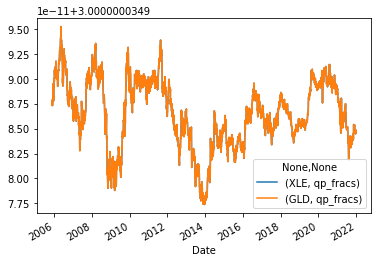

In [85]:
qp_fracs.plot()

In [83]:
eq_fracs

,XLE,GLD
,eq_fracs,eq_fracs
Date,,
2004-11-18,NaN,NaN
2004-11-19,NaN,NaN
2004-11-22,NaN,NaN
2004-11-23,NaN,NaN
2004-11-24,NaN,NaN
...,...,...
2021-12-23,0.5,0.5
2021-12-27,0.5,0.5


In [132]:
a = datayf.GLD.pct_change().rolling(
        252).cov()['Close'].to_numpy()
b = datayf.XLE.pct_change().rolling(
        252).cov()['Close'].to_numpy()
a


array([           nan,            nan,            nan, ...,
       7.42353639e-05, 7.41786635e-05, 7.41498767e-05])

In [131]:
a_sharp = datayf.GLD.pct_change() / datayf.GLD.pct_change().std()
b_sharp = datayf.XLE.pct_change() / datayf.GLD.pct_change().std()

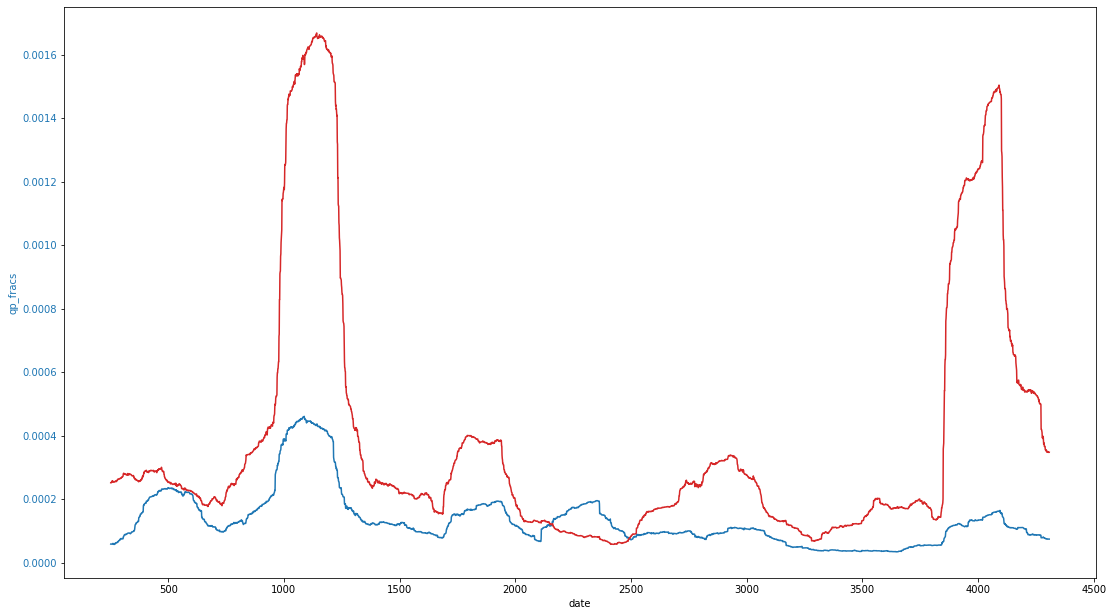

In [133]:

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel('qp_fracs', color=color)
ax1.plot(a, color=color)
ax1.plot(b, color='tab:red')
ax1.tick_params(axis='y', labelcolor=color)


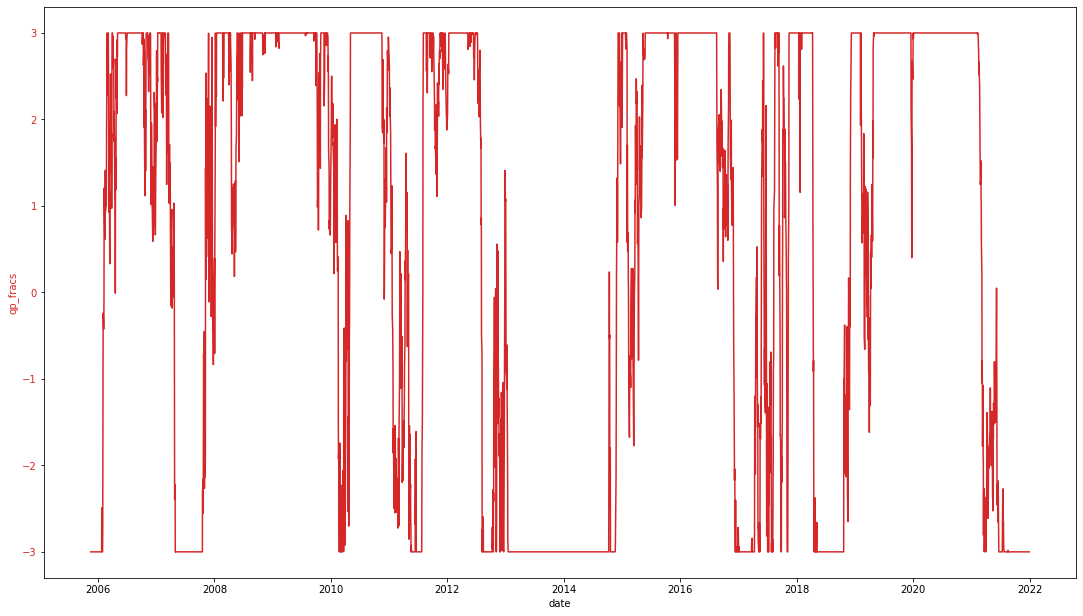

In [104]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('qp_fracs', color=color)
ax1.plot(qp_fracs.XLE - qp_fracs.GLD, color=color)
ax1.tick_params(axis='y', labelcolor=color)

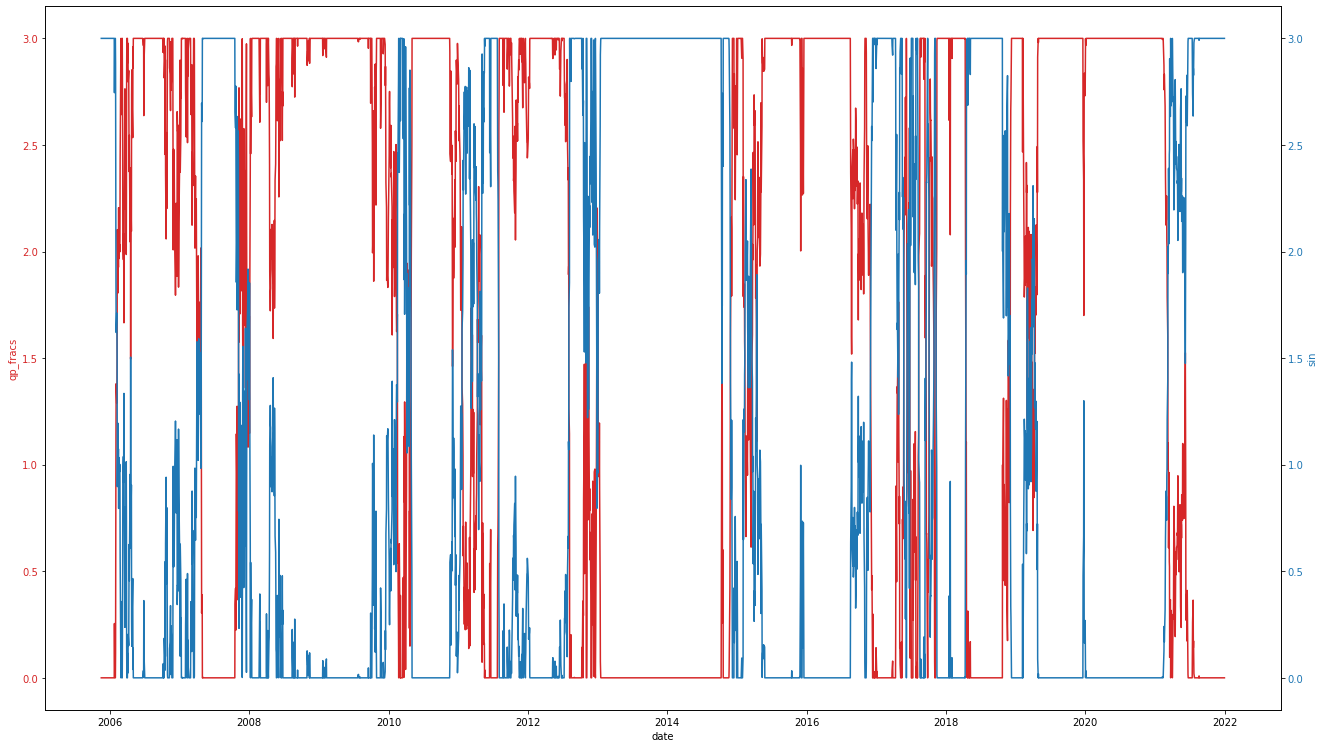

In [99]:

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('qp_fracs', color=color)
ax1.plot(qp_fracs.XLE, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(qp_fracs.GLD, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# plt.plot(datayf.SPY)

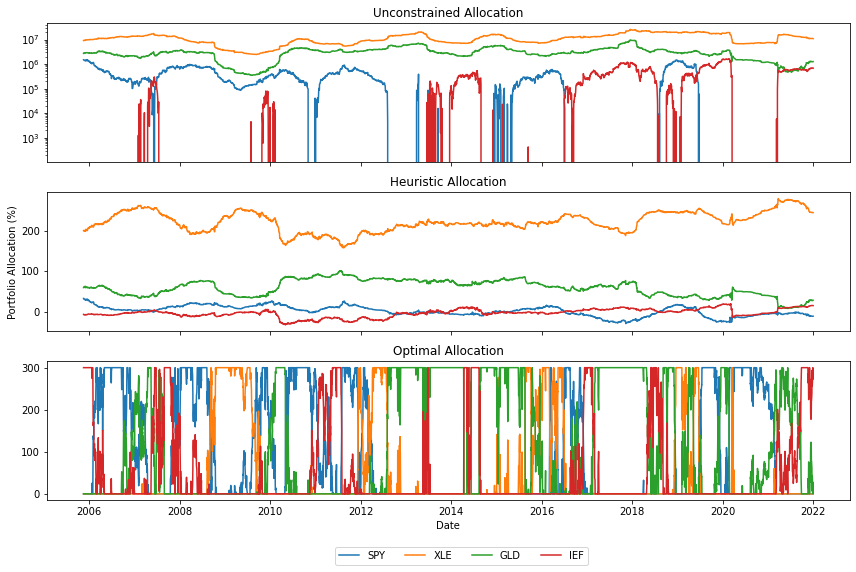

In [30]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels = opt.tickers

fig, ax = plt.subplots(3, figsize=(12, 8), sharex=True)

ax[0].plot(uc_fracs * 100)
ax[0].set_title('Unconstrained Allocation')
ax[0].semilogy()

ax[1].plot(heur_fracs * 100)
ax[1].set_ylabel('Portfolio Allocation (%)')
ax[1].set_title('Heuristic Allocation')

ax[2].plot(qp_fracs * 100)
ax[2].set_xlabel('Date')
ax[2].set_title('Optimal Allocation')
ax[2].legend(labels=labels, ncol=len(labels),
             bbox_to_anchor=(0.68, -0.3))

plt.tight_layout()
plt.show()

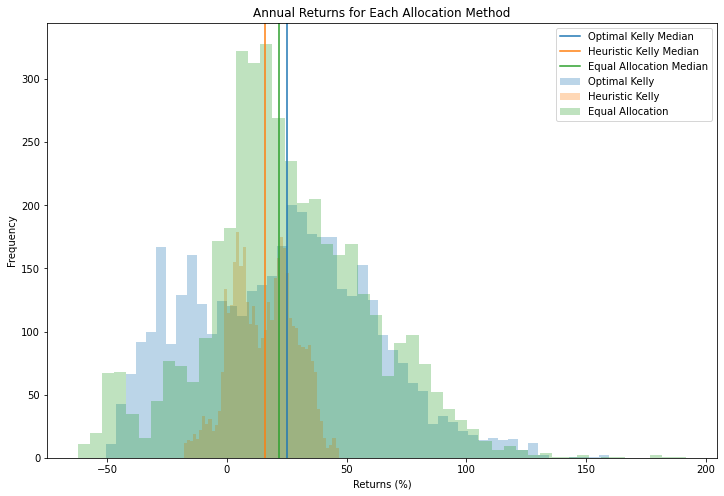

In [31]:
log_rets = np.log(opt.data.loc[:, (slice(None), "returns")].values)

heur_rets = log_rets * heur_fracs.shift(1)
heur_log_rets_ann = heur_rets.sum(axis=1).rolling(252).sum().dropna()
heur_rets_ann = (np.exp(heur_log_rets_ann) - 1) * 100

eq_rets = log_rets * eq_fracs.shift(1) * opt.max_leverage
eq_log_rets_ann = eq_rets.sum(axis=1).rolling(252).sum().dropna()
eq_rets_ann = (np.exp(eq_log_rets_ann) - 1) * 100

qp_rets = log_rets * qp_fracs.shift(1)
qp_log_rets_ann = qp_rets.sum(axis=1).rolling(252).sum().dropna()
qp_rets_ann = (np.exp(qp_log_rets_ann) - 1) * 100

plt.figure(figsize=(12, 8))

plt.hist(qp_rets_ann, label="Optimal Kelly", alpha=0.3, bins=50)
plt.axvline(x=np.median(qp_rets_ann), label="Optimal Kelly Median",
            c=colors[0])

plt.hist(heur_rets_ann, label="Heuristic Kelly", alpha=0.3, bins=50)
plt.axvline(x=np.median(heur_rets_ann), label="Heuristic Kelly Median",
            c=colors[1])

plt.hist(eq_rets_ann, label="Equal Allocation", alpha=0.3, bins=50)
plt.axvline(x=np.median(eq_rets_ann), label="Equal Allocation Median",
            c=colors[2])

plt.xlabel('Returns (%)')
plt.ylabel('Frequency')
plt.title('Annual Returns for Each Allocation Method')

plt.legend()
plt.show()